# Cut off upper level inputs

Should happen in the data generator.

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.normalization import *

## Adapt DataGenerator

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    """
    https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

    Data generator class.
    """

    def __init__(self, data_fn, input_vars, output_vars,
                 norm_fn=None, input_transform=None, output_transform=None,
                 batch_size=1024, shuffle=True, xarray=False, var_cut_off=None):
        # Just copy over the attributes
        self.data_fn, self.norm_fn = data_fn, norm_fn
        self.input_vars, self.output_vars = input_vars, output_vars
        self.batch_size, self.shuffle = batch_size, shuffle

        # Open datasets
        self.data_ds = xr.open_dataset(data_fn)
        if norm_fn is not None: self.norm_ds = xr.open_dataset(norm_fn)

        # Compute number of samples and batches
        self.n_samples = self.data_ds.vars.shape[0]
        self.n_batches = int(np.floor(self.n_samples) / self.batch_size)

        # Get input and output variable indices
        self.input_idxs = return_var_idxs(self.data_ds, input_vars, var_cut_off)
        self.output_idxs = return_var_idxs(self.data_ds, output_vars)
        self.n_inputs, self.n_outputs = len(self.input_idxs), len(self.output_idxs)

        # Initialize input and output normalizers/transformers
        if input_transform is None:
            self.input_transform = Normalizer()
        elif type(input_transform) is tuple:
            self.input_transform = InputNormalizer(
                self.norm_ds, input_vars, input_transform[0], input_transform[1], var_cut_off)
        else:
            self.input_transform = input_transform  # Assume an initialized normalizer is passed

        if output_transform is None:
            self.output_transform = Normalizer()
        elif type(output_transform) is dict:
            self.output_transform = DictNormalizer(self.norm_ds, output_vars, output_transform)
        else:
            self.output_transform = output_transform  # Assume an initialized normalizer is passed

        # Now close the xarray file and load it as an h5 file instead
        # This significantly speeds up the reading of the data...
        if not xarray:
            self.data_ds.close()
            self.data_ds = h5py.File(data_fn, 'r')

    def __len__(self):
        return self.n_batches

    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size

        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]

        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]

        # Normalize
        X = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)

        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(self.n_batches)
        if self.shuffle: np.random.shuffle(self.indices)

In [20]:
def return_var_idxs(ds, var_list, var_cut_off=None):
    """
    To be used on stacked variable dimension. Returns indices array

    Parameters
    ----------
    ds: xarray dataset
    var_list: list of variables

    Returns
    -------
    var_idxs: indices array

    """
    if var_cut_off is None:
        var_idxs = np.concatenate([np.where(ds.var_names == v)[0] for v in var_list])
    else:
        idxs_list = []
        for v in var_list:
            i = np.where(ds.var_names == v)[0]
            if v in var_cut_off.keys():
                i = i[var_cut_off[v]:]
            idxs_list.append(i)
        var_idxs = np.concatenate(idxs_list)
    return var_idxs

In [7]:
inputs =  ['QBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']
outputs =  ['PHQ', 'TPHYSTND', 'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT']

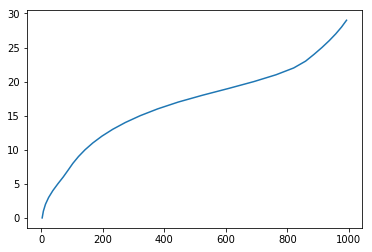

In [12]:
plt.plot(P, range(30))

In [13]:
P

array([  3.6434655,   7.5948195,  14.356632 ,  24.61222  ,  38.2683   ,
        54.595478 ,  72.01245  ,  87.82123  , 103.31713  , 121.54725  ,
       142.99405  , 168.22508  , 197.90808  , 232.82861  , 273.91083  ,
       322.24188  , 379.1009   , 445.99258  , 524.6872   , 609.7787   ,
       691.3894   , 763.4045   , 820.85834  , 859.53485  , 887.0203   ,
       912.64453  , 936.1984   , 957.4855   , 976.32544  , 992.5561   ],
      dtype=float32)

In [14]:
var_cut_off = {
    'QBP': 10,
    'TBP': 10,
}

In [21]:
gen = DataGenerator('/local/S.Rasp/preprocessed_data/001_train.nc', inputs, outputs,
                    xarray=True, shuffle=False, var_cut_off=var_cut_off)

In [22]:
X, Y = gen[0]

In [24]:
X.shape, Y.shape

((1024, 74), (1024, 65))

## Adapt Normalization

In [26]:
class InputNormalizer(object):
    """Normalizer that subtracts and then divides."""
    def __init__(self, norm_ds, var_list, sub='mean', div='std_by_var', var_cut_off=None):
        var_idxs = return_var_idxs(norm_ds, var_list, var_cut_off)
        self.sub = norm_ds[sub].values[var_idxs]
        if div == 'maxrs':
            rang = norm_ds['max'][var_idxs] - norm_ds['min'][var_idxs]
            std_by_var = rang.copy()
            for v in var_list:
                std_by_var[std_by_var.var_names == v] = norm_ds['std_by_var'][
                    norm_ds.var_names_single == v]
            self.div = np.maximum(rang, std_by_var).values
        elif div == 'std_by_var':
            # SR: Total mess. Should be handled better
            tmp_var_names = norm_ds.var_names[var_idxs]
            self.div = np.zeros(len(tmp_var_names))
            for v in var_list:
                std_by_var = norm_ds['std_by_var'][norm_ds.var_names_single == v]
                self.div[tmp_var_names == v] = std_by_var
        else:
            self.div = norm_ds[div].values[var_idxs]
        self.transform_arrays = {
            'sub': self.sub,
            'div': self.div
        }

    def transform(self, x):
        return (x - self.sub) / self.div

    def inverse_transform(self, x):
        return (x * self.div) + self.sub

In [27]:
norm_ds = xr.open_dataset('/local/S.Rasp/preprocessed_data/001_norm.nc')

In [31]:
in_norm = InputNormalizer(norm_ds, inputs, div='maxrs', var_cut_off=var_cut_off)

In [32]:
in_norm.div.shape

(74,)

In [34]:
import json

In [37]:
json.loads('{"QBP": 10, "TBP": 10}')

{'QBP': 10, 'TBP': 10}